In [2]:
from astropy.io import fits

# open fits file as fits_file
fits_file = fits.open('ngc1261.fits')
print(fits_file)

In [3]:
# extract data from the fits file
image_data = fits_file[0].data
print(image_data)

[[-25. -25. -25. ... -25. -25. -25.]
 [-25. -25. -25. ... -25. -25. -25.]
 [-25. -25. -25. ... -25. -25. -25.]
 ...
 [-25. -25. -25. ... -25. -25. -25.]
 [-25. -25. -25. ... -25. -25. -25.]
 [-25. -25. -25. ... -25. -25. -25.]]


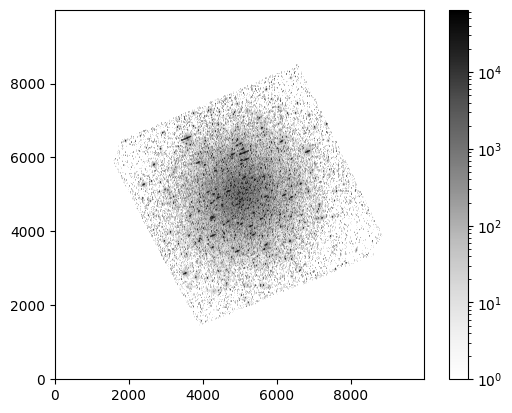

In [4]:
# dispay image with matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.figure()
plt.imshow(image_data, origin = 'lower', cmap='Greys', norm=LogNorm())
plt.colorbar()
plt.show()

In [5]:
# It's easier to focus on a small part of the data at a time, so we need to pick an x any y range.
# Let's start by finding the precise size (area) of our image in pixels.
fits_file.info()

Filename: ngc1261.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   (10000, 10000)   float32   


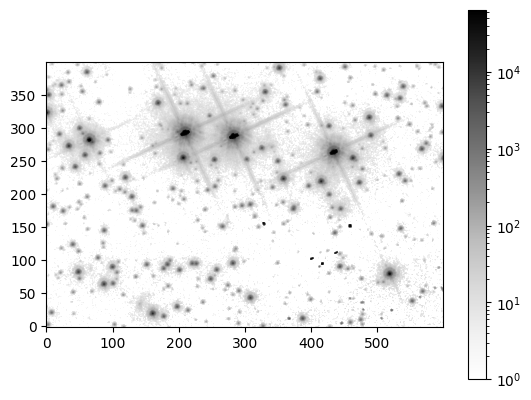

In [6]:
# only display a portion of the data
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# change working data to "image_data[y:y, x:x]"
section1 = image_data[2250:2650, 5350:5950]

# plt.imshow "section1"
plt.figure()
plt.imshow(section1, origin = 'lower', cmap='Greys', norm=LogNorm())
plt.colorbar()
plt.show()

In [7]:
'''find mean, median, and standard deviation'''

from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(section1,sigma=3.0)
# print data
print((mean,median,std))

(1.6487273, 0.0, 8.310026)


In [8]:
'''Use DAOStarFinder to detect stars'''

from photutils.detection import DAOStarFinder

# find stars that have a full-width-half-maximum of about 3 pixels and
# are at least 5 sigma above the background level
daofind = DAOStarFinder(fwhm = 3.0, threshold = 5.0*std)

# define table named "sources"
sources = daofind(section1 - median)

# format sources table
for col in sources.colnames:
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'

# print table (make sure to use 'p-print' not just 'print')
sources.pprint(max_width = 76)

 id xcentroid ycentroid sharpness roundness1 ... sky    peak   flux  mag 
--- --------- --------- --------- ---------- ... ---- ------- ----- -----
  1    117.20      0.34      0.88      -0.20 ... 0.00  199.00  3.38 -1.32
  2    428.44      0.36      0.77      -0.29 ... 0.00  168.00  2.93 -1.17
  3    327.47      1.06      0.51       0.02 ... 0.00  619.00 13.01 -2.79
  4      2.78      3.20      0.49      -0.01 ... 0.00  660.00 13.98 -2.86
  5    103.18      3.44      0.66       0.10 ... 0.00  407.00  7.17 -2.14
  6    477.76      3.68      0.59       0.00 ... 0.00  258.00  4.72 -1.68
  7    290.51      5.25      0.46       0.19 ... 0.00  302.00  6.52 -2.04
  8    446.31      5.24      0.77       0.39 ... 0.00 1772.00 33.91 -3.83
  9    459.62      6.53      0.70       0.45 ... 0.00  960.00 15.98 -3.01
 10    241.68      7.76      0.53       0.21 ... 0.00  113.00  2.45 -0.97
...       ...       ...       ...        ... ...  ...     ...   ...   ...
409    496.71    392.87      0.53     

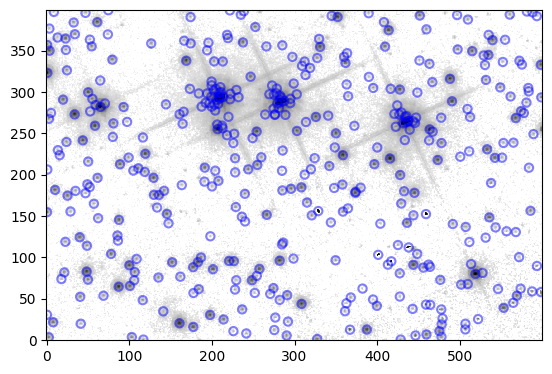

In [9]:
'''visualize detected stars with matplotlib'''

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from photutils.aperture import CircularAperture

# define star positions based on sources table, then draw 
# apertures around each position (radius 5) and plot data
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r = 5.0)
plt.imshow(section1, cmap = 'Greys', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')

# draw apertures. apertures.plot command takes arguments (color, line-width, and opacity (alpha))
apertures.plot(color = 'blue', lw = 1.5, alpha = 0.5);

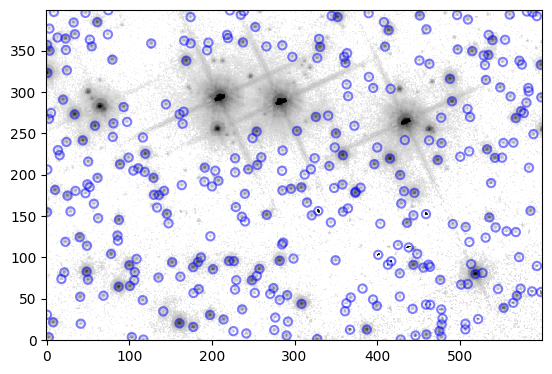

In [10]:
'''Mask regions with bright stars'''

mask = np.zeros(section1.shape, dtype=bool)

# select regions to mask (y:y,x:x)
mask[260:320,40:80] = True
mask[230:350,170:240] = True
mask[260:340,240:320] = True
mask[250:330,420:470] = True

# redefine sources table
sources = daofind(section1-median,mask=mask)
xpix = sources['xcentroid']
ypix = sources['ycentroid']

# plot new table
positions = np.transpose((xpix,ypix))
apertures = CircularAperture(positions,r=5.0)
plt.imshow(section1, cmap='Greys', norm=LogNorm(), origin = 'lower', interpolation='nearest')
apertures.plot(color='blue',lw=1.5, alpha = 0.5);

In [11]:
'''use find_peaks to detect stars'''

from astropy.stats import sigma_clipped_stats
from photutils.detection import find_peaks

# define mean, median, and std
mean, median, std = sigma_clipped_stats(section1, sigma = 3.0)

# find stars that are at least 5 sigma above background and 
# separated by at least 5 pixels
threshold = median + (5.0*std)

# define, format, and print table of peak values
tbl = find_peaks(section1, threshold, box_size = 11)
tbl['peak_value'].info.format = '%8g'
print(tbl)

x_peak y_peak peak_value
------ ------ ----------
   117      0        199
   428      0        168
   327      1        656
     3      3        660
   103      3        407
   291      5        318
   446      5       1772
   460      7        960
   242      8        113
   226     10         66
   ...    ...        ...
   235    394         87
    47    395        110
   390    395        105
   482    395         43
   258    396         47
   588    396        146
     9    397         70
   581    397        122
    75    399         93
   170    399        104
   222    399        114
Length = 530 rows


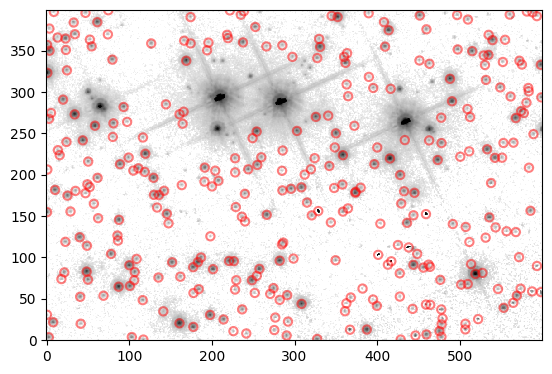

In [12]:
'''visualize locations of detected peaks with matplotlib'''

# define positions based on peak table and plot data
postitions = np.transpose((tbl['x_peak'], tbl['y_peak']))
plt.imshow(section1, cmap = 'Greys', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')

# plot apertures, but change color to distinguish from DAOStarFinder data
apertures.plot(color = 'red', lw = 1.5, alpha = 0.5);

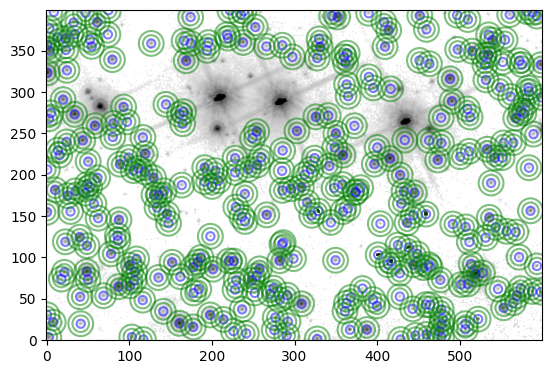

In [13]:
# variable "section1" contains our image data
# variable "positions" contains our positions
# variable "apertures" contains our aperture data

'''find background values by drawing an annulus around each star'''

# import tools
from photutils.aperture import CircularAnnulus, CircularAperture, ApertureStats, aperture_photometry

# define annuluses
annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)

# plot annuluses
plt.figure()
plt.imshow(section1, cmap='Greys', norm = LogNorm(), origin = 'lower')
apertures.plot(color='blue',lw=1.5, alpha = 0.5);
annulus_aperture.plot(color='green',lw=1.5,alpha=0.5);
plt.show()

In [14]:
# define background
aperstats = ApertureStats(section1, annulus_aperture)
bkg_mean = aperstats.mean
aperture_area = apertures.area_overlap(section1)
total_bkg = bkg_mean*aperture_area

# perform aperture photometry
star_data = aperture_photometry(section1, apertures)

# add backgrounds to table
star_data['total_bkg'] = total_bkg

# format and print data
for col in star_data.colnames:
    star_data[col].info.format = '%.8g'
star_data.pprint()


 id  xcenter   ycenter   aperture_sum total_bkg 
       pix       pix                            
--- --------- ---------- ------------ ----------
  1 117.19841 0.33785036    967.29562  411.21136
  2 428.43611 0.35907893    1134.1804 -105.48141
  3 327.47384  1.0581984    5942.7364 -11.126172
  4 2.7816756  3.1995047    6895.5637  50.169515
  5 103.18459  3.4357617    3531.7091 -37.972177
  6 477.75663  3.6764751    2785.9139  617.26379
  7 290.51092   5.254984    3165.6819 -7.0288552
  8 446.31111  5.2372901    6604.7038  2217.7566
  9 459.61981  6.5305425    8881.3539  2361.9695
 10 241.67749  7.7623865    706.04205 -387.24493
...       ...        ...          ...        ...
319 560.32002  393.47255    1378.4357 -262.91128
320 235.09138  393.29922    1217.3452  125.96578
321 47.174244  395.56539    968.20699  392.86449
322 389.72428  395.12727    827.51614 -106.88696
323 8.8729477  396.68106    637.12651 -79.693429
324 587.87268   396.1748    1374.7063 -228.49119
325 581.10246  397.1

In [16]:
'''
Find zeropoint from catalogue based on filter and instrument.
Install acs tools by typing the following command into the terminal:

    >> pip install acstools
'''

from acstools import acszpt

# find date in header (>> more 'ngc1261.fits')
date = '2006-03-10'

# find intrument in header (>> more 'ngc1261.fits')
instrument = 'WFC'

# find filter in header (>> more 'ngc1261.fits')
filter = 'F814W'

# fetch zeropoint from catalogue
q = acszpt.Query(date = date, detector = instrument)
zpt_table = q.fetch()
q_filter = acszpt.Query(date = date, detector = instrument, filt = filter)
filter_zpt = q_filter.fetch()

# print data
print(filter_zpt)

Filter PHOTLAM             PHOTFLAM            STmag  VEGAmag  ABmag 
       Angstrom erg / (Angstrom cm2 electron) mag(ST)   mag   mag(AB)
------ -------- ----------------------------- ------- ------- -------
 F814W   8047.9                    7.0156e-20  26.785  25.517  25.948


In [17]:
''' 
Enter zeropoint and exposure time (exposure time found in header), and use them to
calculate magnitudes. To calculate magnitudes, use the equation:

    MAGNITUDE = ZEROPOINT - 2.5*log_10{(APERTURE_SUM - TOTAL_BKG)/EXTIME}
'''

# use ABmag from filter_zpt
zeropoint = 25.948

# find exposure time in header (>> more 'ngc1261.fits')
extime = 1800

# calculate magnitudes
import math
magnitudes = []
for line in star_data:
    magnitudes.append(zeropoint - (2.5*math.log10(abs(line[3]-line[4])/extime)))

# add magnitudes to table and print data
star_data['magnitude'] = magnitudes
star_data.pprint(max_lines = -1, max_width = -1)

 id  xcenter    ycenter   aperture_sum  total_bkg      magnitude     
       pix        pix                                                
--- ---------- ---------- ------------ ----------- ------------------
  1  117.19841 0.33785036    967.29562   411.21136 27.223329764320102
  2  428.43611 0.35907893    1134.1804  -105.48141  26.35292320410677
  3  327.47384  1.0581984    5942.7364  -11.126172 24.649184254676186
  4  2.7816756  3.1995047    6895.5637   50.169515 24.497685107644685
  5  103.18459  3.4357617    3531.7091  -37.972177  25.20460766157207
  6  477.75663  3.6764751    2785.9139   617.26379 25.745707545067795
  7  290.51092   5.254984    3165.6819  -7.0288552 25.332605058786893
  8  446.31111  5.2372901    6604.7038   2217.7566 24.980775235627075
  9  459.61981  6.5305425    8881.3539   2361.9695 24.550664786989138
 10  241.67749  7.7623865    706.04205  -387.24493 26.489345822406346
 11   226.1103  10.548382    180.47829  -241.71508  27.52240275494668
 12   475.2584  10.6